# IA353 - Redes Neurais
# EFC2 - Questão 5b

## Denoising autoencoder for fashionmnist data base


**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** Matheus dos Santos Rodrigues  

*Um autoencoder convolucional foi proposto para a remoção de ruídos aleatórios de imagens da base fashionmnist*

### 5.1. Imports

In [ ]:
import tensorflow as tf
import os

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.neighbors import NearestNeighbors

from keras import layers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Convolution2D,Convolution2DTranspose, MaxPooling2D, Flatten, Input
# from keras.optimizers import adam
from keras.utils.np_utils import to_categorical

### 5.2. Reading the data and adding noise


In [ ]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train),(x_test, y_test) = fmnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
# Adding noise to the data
noise_factor = 0.25
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [ ]:
x_train_images = x_train.reshape(x_train.shape[0], 28, 28)
x_train_noisy_images = x_train_noisy.reshape(x_train.shape[0], 28, 28)
x_test_images = x_test.reshape(x_test.shape[0], 28, 28)
x_test_noisy_images = x_test_noisy.reshape(x_test.shape[0], 28, 28)

In [ ]:
# Definition of a function to visualize some images
def show(img):
    plt.imshow(img, cmap = "gray", interpolation = "none")

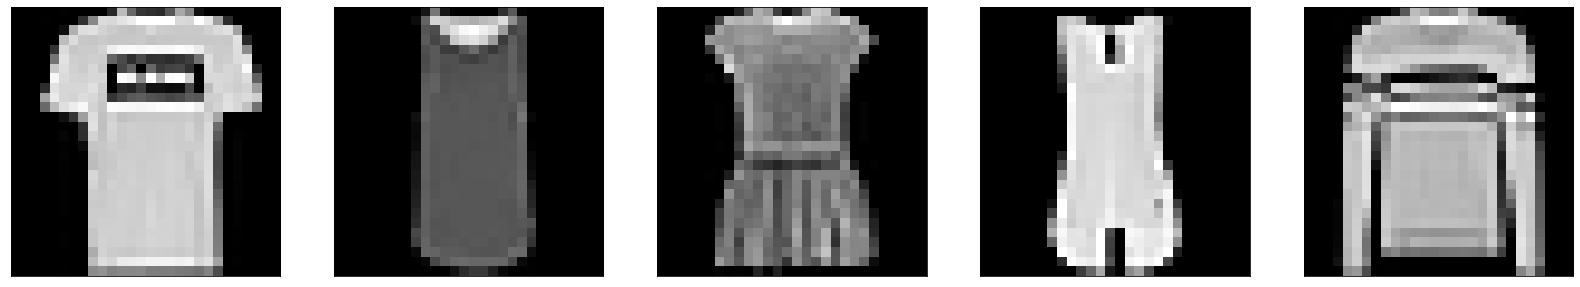

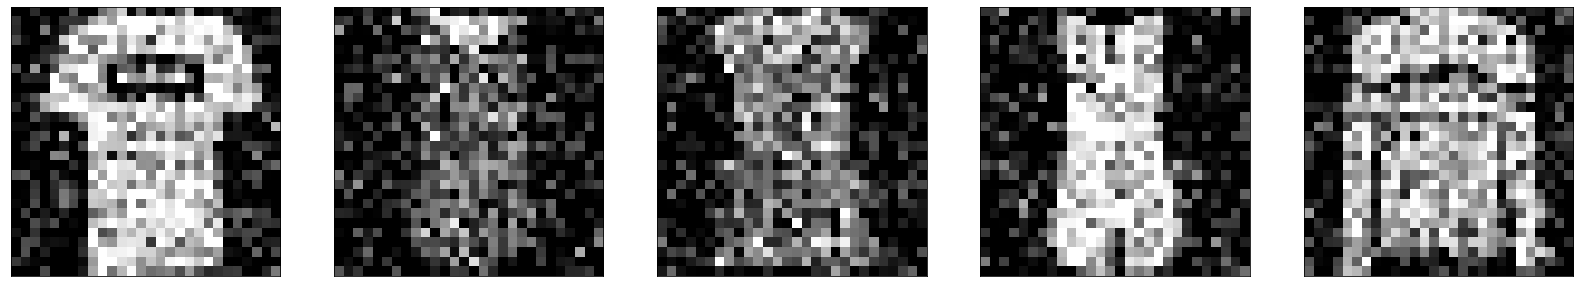

In [ ]:
# Visualization of 25 x 25 original images
fig = plt.figure(figsize=(28,28))
ind = 1
for i in range(1, 2, 1):
    for j in range(1, 6, 1):
        fig.add_subplot(1,5,ind)
        show(x_train_images[ind])
        plt.xticks([])
        plt.yticks([])
        ind+=1

fig2 = plt.figure(figsize=(28,28))
ind2 = 1
for k in range(1, 2, 1):
    for l in range(1, 6, 1):
        fig2.add_subplot(1,5,ind2)
        show(x_train_noisy_images[ind2])
        plt.xticks([])
        plt.yticks([])
        ind2+=1

### 5.3 Proposal for the autoencoder architecture

*A arquitetura proposta para o denoising autoencoder é semelhante ao apresentado para a questão 5.1. Neste modelo, no entanto, foi removido o bottleneck de dimensão "2" para dar mais flexibilidade a rede.*

In [ ]:
input_img = Input(shape=(784,))

encoded = layers.Reshape((28,28,1))(input_img)

encoded = Convolution2D(filters=32, kernel_size=(15, 15), strides=1, activation='relu')(encoded)
encoded = Convolution2D(filters=64, kernel_size=(8, 8), strides=1, activation='relu')(encoded)
encoded = Convolution2D(filters=128, kernel_size=(5, 5), strides=1, activation='relu')(encoded)

encoded = layers.Flatten() (encoded)
#encoded = Dense(2)(encoded) # Linear activation function at the bottleneck
decoded = Dense(1152, activation='tanh')(encoded)
decoded = layers.Dropout(0.5)(decoded)

decoded = layers.Reshape((3,3,128))(decoded)
decoded = layers.Conv2DTranspose(filters=64, kernel_size=(7, 7), strides=4, activation='relu')(decoded)
decoded = layers.Conv2DTranspose(filters=32, kernel_size=(14, 14), strides=1, activation='relu')(decoded)
decoded = layers.Conv2DTranspose(filters=1, kernel_size=(1, 1), strides=1, activation='relu')(decoded)
decoded = layers.Reshape((784,))(decoded)

autoencoder = Model(input_img, decoded)

In [ ]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        7232      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          131136    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 128)         204928    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1152)              1328

In [ ]:
autoencoder.compile(optimizer = "adam", loss = "msle")
X_noisy = x_train_noisy.reshape(x_train_noisy.shape[0], 784)
X = x_train.reshape(x_train.shape[0], 784)
history = autoencoder.fit(X_noisy, X, batch_size = 128, epochs = 10, verbose = 1)

Epoch 1/10
469/469 [==============================] - 7s 15ms/step - loss: 0.0384
Epoch 2/10
469/469 [==============================] - 7s 15ms/step - loss: 0.0110
Epoch 3/10
469/469 [==============================] - 7s 15ms/step - loss: 0.0092
Epoch 4/10
469/469 [==============================] - 7s 15ms/step - loss: 0.0083
Epoch 5/10
469/469 [==============================] - 7s 15ms/step - loss: 0.0076
Epoch 6/10
469/469 [==============================] - 7s 15ms/step - loss: 0.0072
Epoch 7/10
469/469 [==============================] - 7s 15ms/step - loss: 0.0068
Epoch 8/10
469/469 [==============================] - 7s 15ms/step - loss: 0.0065
Epoch 9/10
469/469 [==============================] - 7s 15ms/step - loss: 0.0063
Epoch 10/10
469/469 [==============================] - 7s 14ms/step - loss: 0.0061


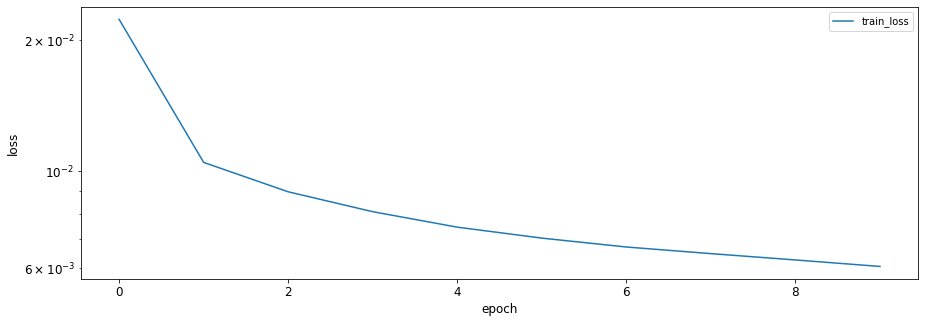

In [ ]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

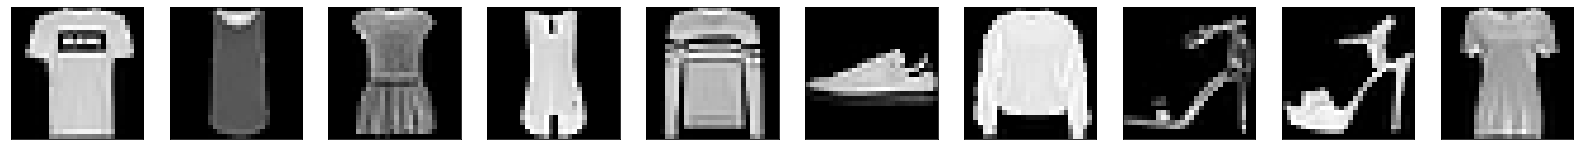

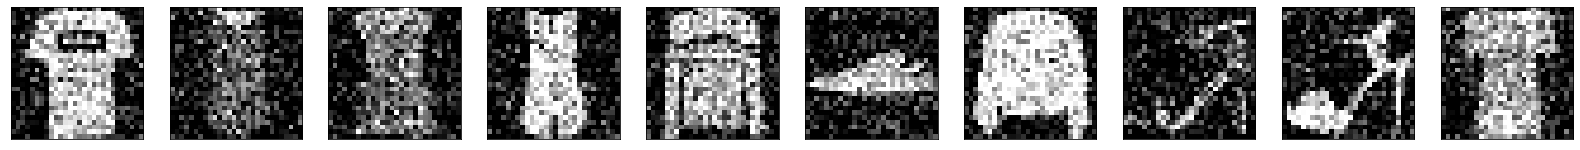

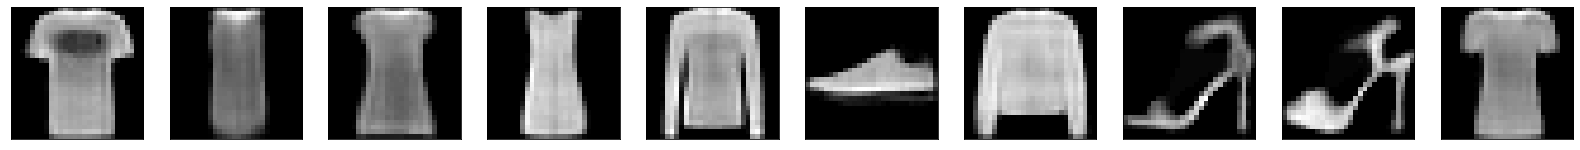

In [ ]:
# Visualization of 1 x 10 original images
fig1 = plt.figure(figsize=(28,28))
ind1 = 1
for i in range(1, 2, 1):
    for j in range(1, 11, 1):
        fig1.add_subplot(1,10,ind1)
        show(x_train_images[ind1])
        plt.xticks([])
        plt.yticks([])
        ind1+=1
# Visualization of 1 x 10 images with noise
fig2 = plt.figure(figsize=(28,28))
ind2 = 1
for k in range(1, 2, 1):
    for l in range(1, 11, 1):
        fig2.add_subplot(1,10,ind2)
        show(x_train_noisy_images[ind2])
        plt.xticks([])
        plt.yticks([])
        ind2+=1
# Visualization of 1 x 10 reconstructed images 
fig3 = plt.figure(figsize=(28,28))
ind3 = 1
for i in range(1, 2, 1):
    for j in range(1, 11, 1):
        fig3.add_subplot(1,10,ind3)
        show(autoencoder.predict(np.expand_dims(x_train_noisy_images[ind3].flatten(), 0)).reshape(28, 28))
        plt.xticks([])
        plt.yticks([])
        ind3+=1

### 5.4 Denoising test data

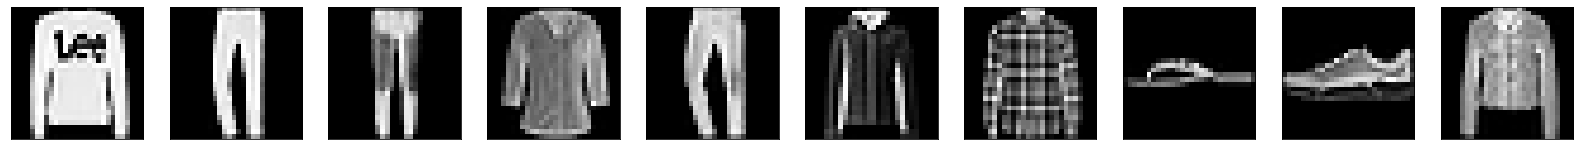

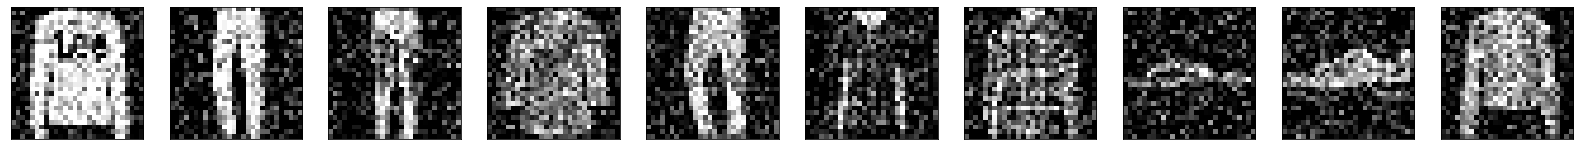

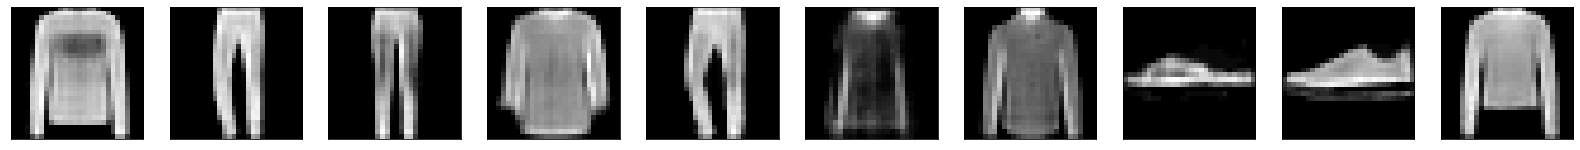

In [ ]:
# Visualization of 1 x 10 original images 
fig1 = plt.figure(figsize=(28,28))
ind1 = 1
for i in range(1, 2, 1):
    for j in range(1, 11, 1):
        fig1.add_subplot(1,10,ind1)
        show(x_test_images[ind1])
        plt.xticks([])
        plt.yticks([])
        ind1+=1

# Visualization of 1 x 10 images with noise
fig2 = plt.figure(figsize=(28,28))
ind2 = 1
for k in range(1, 2, 1):
    for l in range(1, 11, 1):
        fig2.add_subplot(1,10,ind2)
        show(x_test_noisy_images[ind2])
        plt.xticks([])
        plt.yticks([])
        ind2+=1

# Visualization of 1 x 10 reconstructed images 
fig3 = plt.figure(figsize=(28,28))
ind3 = 1
for i in range(1, 2, 1):
    for j in range(1, 11, 1):
        fig3.add_subplot(1,10,ind3)
        show(autoencoder.predict(np.expand_dims(x_test_noisy_images[ind3].flatten(), 0)).reshape(28, 28))
        plt.xticks([])
        plt.yticks([])
        ind3+=1